# Project Overview
In this project we will attempt to implement a basic Seq2Seq model architecture and train it to create transliterations from Russian to English. A transliteration is a form of translation where we aim to keep the pronunciation aspect across the two languages, rather than keeping the semantic meaning.  

### Import Libraries

We start this project by importing the common libraries that will be used throughout.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset

### Dataset

The dataset for this project was found on [Kaggle](https://www.kaggle.com/datasets/colesuoseue/2m-rus2eng-transliterated?resource=download). It contains 2.3 million examples of Russian to English transliterations, as well as weights that represent how common a transliteration is. Our file is in a .parquet format, which stores column-wise rather than row-wise. Overall, this doesn't impact our process in any way but is something to note.

We start by reading the data into a pandas table and taking a look at some of its samples.

In [2]:
db = pd.read_parquet("rus_to_en_data.parquet")
print(db.head())
print(len(db))

  original_word transliteration  weight
0            аа              aa     1.0
1           ааа             aaa     1.0
2        аагатэ          aagate     1.0
3        аагатэ          aahate     0.3
4        аагатэ         aagathe     0.5
2314084


Everything works! As we can see the original_word is the Russian word and the transliteration is the phonetic representation of it in English. Also note the weights of the transliteration. They represent how common a transliteration is and are marked on a scale of 0-1 but that does not mean that the different transliterations of the same word will sum up to 1.

Next, we want to make sure to standardize the way the Russian letters get represented in Unicode. We do this via NFC normalization which makes sure we always refer to the dedicated Unicode of the character instead of the alternative where it uses a combination of Unicodes. For example the letter ё could be converted to its own unicode or it could be a combination of a unicode for e and a unicode for the two dots.

In [ ]:
import unicodedata
db["original_word"] = db["original_word"].apply(lambda x: unicodedata.normalize("NFC", x.lower()))
db["transliteration"] = db["transliteration"].apply(lambda x: unicodedata.normalize("NFC", x.lower()))

Now we will create our vocabulary for the two sequences. Since we are dealing with phonetic pronunciations of words it makes sense that our tokens will be just single letters. In order to get this vocab we will get a list of all the unique letters used in our data for each language. 

We will also add tokens that will help us train and infer the model:
- The &lt;pad&gt; token is used to make sure that all of the input strings in the same batch are of the same length, otherwise the encoder would not be able to work
- The &lt;bos&gt; token stands for "beginning of sentence" which is necessary for teacher forcing (more on that later)
- The &lt;eos&gt; token stands for "end of sentence" and is used to end the decoding process
- The &lt;unk&gt; token is for any unknown tokens that the model might see. For our case it is likely unnecessary, but it makes the usage of our model more robust

And we will also define string-to-index and index-to-string dictionaries that will be used for our encode and decode functions.

In [4]:
russian_vocab = list(set("".join(db["original_word"])))
english_vocab = list(set("".join(db["transliteration"])))

print(f"English Vocab Size: {len(english_vocab)}")
print(f"Russian Vocab Size: {len(russian_vocab)}")

russian_vocab = ["<pad>", "<bos>", "<eos>", "<unk>"] + sorted(russian_vocab)
english_vocab = ["<pad>", "<bos>", "<eos>", "<unk>"] + sorted(english_vocab)
PAD_ID = 0; BOS_ID = 1; EOS_ID = 2; UNK_ID = 3

# stoi = string to index, itos = index to string
russian_stoi = {char: idx for idx, char in enumerate(russian_vocab)}
russian_itos = {idx: char for char, idx in russian_stoi.items()}
english_stoi = {char: idx for idx, char in enumerate(english_vocab)}
english_itos = {idx: char for char, idx in english_stoi.items()}

# sanity check
print(english_itos[4], english_stoi["a"])
print(russian_itos[4], russian_stoi["а"])


English Vocab Size: 25
Russian Vocab Size: 33
a 4
а 4


This is a bit of a surprise. Our English vocab is only 25 letters while there are 26 letters in the Latin alphabet. Taking a closer look you can see that the letter *q* is missing from the list of unique characters. If you speak Russian this might not be so surprising to you, it is a sound that is unlike any of the Russian pronunciations. When first thinking about how to set the vocab lengths I thought to just set them to the respective alphabet lengths. Now we can see why that would have been slightly inaccurate to do.

Next, we will create our encode function that will convert the string of characters into a vector of character IDs and the decode function that would undo that change.

In [162]:
def encode(text, stoi):
    tokenized = [stoi["<bos>"]] + [stoi.get(char, stoi["<unk>"]) for char in text] + [stoi["<eos>"]]
    return tokenized

def decode(tokens, itos):
    return "".join([itos.get(token, "<unk>") for token in tokens if itos[token] != "<pad>"])

print(encode("привет", russian_stoi))  
print(decode([1, 19, 20, 12, 6, 9, 22, 2], russian_itos))  

[1, 19, 20, 12, 6, 9, 22, 2]
<bos>привет<eos>


Nice and easy. Next is a train/val/test split of our data. There is an important nuance that we have to be aware of to not mess up our training. There are duplicate words in the dataset with different weights. To avoid having some of the train words in the test set we make sure that all the duplicates stay in the same split. We also shuffle the data to prevent the model from learning the order of the data. 

In [ ]:
db = db.sample(frac=1,random_state=123).reset_index(drop=True)
print(db.head())

uniq_src = db["original_word"].drop_duplicates().sample(frac=1, random_state=123).tolist()

n = len(uniq_src)
n_train = int(n * 0.8)
n_val   = int(n * 0.1)
train_src = set(uniq_src[:n_train])
val_src   = set(uniq_src[n_train:n_train+n_val])
test_src  = set(uniq_src[n_train+n_val:])

train_data = db[db["original_word"].isin(train_src)].reset_index(drop=True)
val_data   = db[db["original_word"].isin(val_src)].reset_index(drop=True)
test_data  = db[db["original_word"].isin(test_src)].reset_index(drop=True)

print(f"Train size: {len(train_data)}, Validation size: {len(val_data)}, Test size: {len(test_data)}")

  original_word transliteration  weight
0  обговоренный   obhouoryennyy    0.09
1      очернять      ochyernyat    0.70
2      фатализм       fathalizm    0.50
3   гандбольный      handbolnii    0.19
4    задушенный    zaduschennyy    0.29
Train size: 1849957, Validation size: 231823, Test size: 232304


Now we get to creating a `DataLoader` class. Before that, we need to create a `Dataset` class, which is rather simple. The only note I have about this process is that we do encode the words and convert the resulting vectors into tensors.

Here come the nuances that you don't learn from reading the textbook. Although the overall architecture of a Seq2Seq model is flexible with the amount of time steps in a sequence, or in our case letters in a word, they don't behave as nicely with batches of variable input lengths. The layers that we will utilize for our model all expect box-shaped tensors, but if some input words are longer than others then we might not have that. That is why we introduced the `<pad>` token. This allows us to pad the batches to make sure that all vectors are of the same length. In order to implement this feature we use a collate function, which are functions that handle how to format the batches cleanly. Fortunately for us PyTorch has a function to handle the padding for us and we don't need to sweat over the implementation details.

After we define the collate function we can finally create our `DataLoader` class and get a step closer to training our model.

In [ ]:
class s2sDataset(Dataset):
    def __init__(self,db, rus_stoi, eng_stoi):
        self.db = db
        self.rus_stoi = rus_stoi
        self.eng_stoi = eng_stoi
        self.rus = db["original_word"].tolist()
        self.eng = db["transliteration"].tolist()
    
    def __len__(self):
        return len(self.db)
    
    def __getitem__(self, idx):
        rus_text = self.rus[idx]
        eng_text = self.eng[idx]
        
        rus_encoded = encode(rus_text, self.rus_stoi)
        eng_encoded = encode(eng_text, self.eng_stoi)

        return {
            "rus": torch.tensor(rus_encoded, dtype=torch.long),
            "eng": torch.tensor(eng_encoded, dtype=torch.long)
        }

def make_collate_fn(PAD_ID = 0):
    def collate_fn(batch):
        rus_batch = [item["rus"] for item in batch]
        eng_batch = [item["eng"] for item in batch]
        
        rus_padded = nn.utils.rnn.pad_sequence(rus_batch, batch_first=True, padding_value=PAD_ID)
        eng_padded = nn.utils.rnn.pad_sequence(eng_batch, batch_first=True, padding_value=PAD_ID)
        # compute true lengths (exclude padding)
        src_len = (rus_padded != PAD_ID).sum(dim=1)
        return {
            "rus": rus_padded,
            "eng": eng_padded,
            "src_len": src_len
        }
    
    return collate_fn

train_dataset = s2sDataset(train_data, russian_stoi, english_stoi)
val_dataset = s2sDataset(val_data, russian_stoi, english_stoi)
test_dataset = s2sDataset(test_data, russian_stoi, english_stoi)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True,  collate_fn=make_collate_fn(PAD_ID))
val_loader   = DataLoader(val_dataset,   batch_size=256, shuffle=False, collate_fn=make_collate_fn(PAD_ID))
test_loader  = DataLoader(test_dataset,  batch_size=256, shuffle=False, collate_fn=make_collate_fn(PAD_ID))

Let's see some examples of our data.

In [8]:
batch_example = next(iter(train_loader))
print(batch_example["rus"].shape, batch_example["eng"].shape)
print(batch_example["rus"][0], batch_example["eng"][0])
print(decode(batch_example["rus"][0].tolist(), russian_itos))
print(decode(batch_example["eng"][0].tolist(), english_itos))

torch.Size([256, 18]) torch.Size([256, 23])
tensor([ 1, 23, 17, 12,  6,  9, 20, 21,  4, 15,  2,  0,  0,  0,  0,  0,  0,  0]) tensor([ 1, 23, 17, 12, 23,  8, 20, 21,  4, 15,  2,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0])
<bos>универсал<eos>
<bos>uniuersal<eos>


### Model Architecture

We are now ready to create our model! For this task we will use a rather bare-bones version of Seq2Seq. For this project we will aim for a mix of simplicity and performance. This is partly because of my resource constraints in terms of compute power and because this notebook is meant to be a semi-educational guide on how these models work rather than a tutorial for creating the best transliteration model possible. 

Here are the details of the model architecture:
- Two embedding layers since we have two different vocabularies, we also use a `padding_idx` parameter so the `<pad>` token never influences any of the gradients
- We use a basic encoder-decoder design 
    - Both of them use GRUs, a form of RNNs that help with vanishing gradient issues that RNNs are notorious for
- Our output layer is a linear layer that takes the hidden state of the decoder and converts it to logits that determine which letter is the most likely to appear next
- We shift the target sequence one to the right in order to facilitate training
- We use a simple dot-product cross attention mechanism. This is not needed for our task because the only relevant context are the letters around the current one, but I thought it would be educational to implement it as well

In [ ]:
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class Seq2SeqModel(nn.Module):
    def __init__(self, src_vocab_size, trg_vocab_size, emb_dim, hidden_dim, padding_idx=0, n_layers=1):
        super(Seq2SeqModel, self).__init__()
        self.src_embedding = nn.Embedding(src_vocab_size, emb_dim, padding_idx=padding_idx)
        self.trg_embedding = nn.Embedding(trg_vocab_size, emb_dim, padding_idx=padding_idx)
        self.encoder = nn.GRU(emb_dim, hidden_dim, n_layers, batch_first=True)
        self.decoder = nn.GRU(emb_dim, hidden_dim, n_layers, batch_first=True)
        self.output  = nn.Linear(hidden_dim, trg_vocab_size)
        self.pad_id  = padding_idx 

    def forward(self, src, trg, src_len):
        src_emb = self.src_embedding(src)                    
        packed = pack_padded_sequence(src_emb, src_len.cpu(), batch_first=True, enforce_sorted=False)
        enc_out_packed, enc_last_hidden = self.encoder(packed)
        enc_out, _ = pad_packed_sequence(enc_out_packed, batch_first=True)  

        trg_emb = self.trg_embedding(trg[:, :-1])            
        dec_output, _ = self.decoder(trg_emb, enc_last_hidden)  

        logits = self.output(dec_output)                     
        return logits, enc_out, enc_last_hidden

### Training
Now we can define our training function. There are some nuances with padding, which as I learned through this project is a common thing for NLP training, but fortunately for us PyTorch abstracts most of these issues     away. 

We do a little extra work here to represent the loss in the best way possible and I'll explain how. The `CrossEntropyLoss` function does return the average token loss per batch which excludes any padding. But each batch could have a different total amount of tokens in them which would make our loss be a tad innacurate of a representation. For example, if we had two batches and their respective token amounts were 100 and 50 using the pure score from `CrossEntropyLoss` would just result in an unweighted average. What we do in the loop is make sure to scale the batch weights accordingly to the amount of tokens in them.

We also utilized a validation set here to monitor the bias-variance tradeoffs and label smoothing to prevent overffiting.

In [10]:
def train(model, train_loader, val_loader, pad_id, optimizer, device, num_epochs=10):

    train_loss_history = []
    val_loss_history = []
    criterion = nn.CrossEntropyLoss(ignore_index=pad_id, label_smoothing=0.1)

    for epoch in range(num_epochs):
        # -------- training loop --------
        model.train()
        token_loss_sum, token_count = 0.0, 0

        for batch in train_loader:
            src = batch["rus"].to(device)
            trg = batch["eng"].to(device)
            src_len = batch["src_len"].to(device)

            optimizer.zero_grad()
            logits, _, _ = model(src, trg, src_len=src_len)
            loss = criterion(
                logits.view(-1, logits.size(-1)),
                trg[:, 1:].reshape(-1)
            )
            loss.backward()
            optimizer.step()

            with torch.no_grad():
                valid = (trg[:, 1:] != pad_id).sum().item()
                token_loss_sum += loss.item() * valid
                token_count += valid

        avg_token_loss = token_loss_sum / max(1, token_count)
        train_loss_history.append(avg_token_loss)

        # -------- validation loop --------
        model.eval()
        val_loss_sum, val_token_count = 0.0, 0
        with torch.no_grad():
            for batch in val_loader:
                src = batch["rus"].to(device)
                trg = batch["eng"].to(device)
                src_len = batch["src_len"].to(device)

                logits, _, _ = model(src, trg, src_len=src_len)
                val_loss = criterion(
                    logits.view(-1, logits.size(-1)),
                    trg[:, 1:].reshape(-1)
                )
                valid = (trg[:, 1:] != pad_id).sum().item()
                val_loss_sum += val_loss.item() * valid
                val_token_count += valid

        avg_val_loss = val_loss_sum / max(1, val_token_count)
        val_loss_history.append(avg_val_loss)

        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"train_loss={avg_token_loss:.4f}, "
              f"val_loss={avg_val_loss:.4f}")

    return train_loss_history, val_loss_history

### Inference/Decoding

Our model learns the probabilities of the next tokens given the currently selected one, we can express this as $p(x_T | x_{t < T})$ where $x_T$ is the token we are trying to generate. Given these probabilities we need to select tokens until we hit an `<eos>` one. There are multiple ways to do this, one of the most common one being beam search, but for our case greedy decoding seems adequate.

Greedy decoding is where we simply choose the most likely token at every step of the way and add it to our output. This does not necessarily produce the most likely sequence. We could have a scenario where the most likely sequence actually starts with the second most likely token but because it "flows" better with the next tokens the entire sequence is actually a more probable sample compared to any greedy-based algorithms. However, for our purposes the transliterations from a Russian letter to an English one is close to a one-to-one mapping in most scenarios and therefore picking the most probable transliteration is often good enough. Also this is by far the fastest algorithm, the prominent beam search is about *k* times slower where *k* is the number of paths we keep at each timestep.

As a side note, I did try using beam search and found that the difference in the metric that we use to judge our model was about 0.4% in favor of beam search, but it was significantly slower as we predicted.

In [ ]:
@torch.no_grad()
def greedy_decode(model, src, bos_id, eos_id, device, max_length=20, src_len=None):
    model.eval()
    pad_id = getattr(model, "pad_id", 0)

    src = src.to(device)
    if src_len is None:
        src_len = (src != pad_id).sum(dim=1)

    src_emb = model.src_embedding(src)
    packed = pack_padded_sequence(src_emb, src_len.cpu(), batch_first=True, enforce_sorted=False)
    enc_out_packed, enc_last_hidden = model.encoder(packed)
    enc_out, _ = pad_packed_sequence(enc_out_packed, batch_first=True)  

    batch_size = src.size(0)
    trg_input = torch.full((batch_size, 1), bos_id, dtype=torch.long, device=device)
    trg_output = [] 

    dec_hidden = enc_last_hidden
    finished = torch.zeros(batch_size, dtype=torch.bool, device=device)

    for _ in range(max_length):
        trg_emb = model.trg_embedding(trg_input)              
        dec_out, dec_hidden = model.decoder(trg_emb, dec_hidden)  

        scores = torch.bmm(dec_out, enc_out.transpose(1, 2))
        if pad_id is not None:
            enc_pad_mask = (src == pad_id).unsqueeze(1)       
            scores = scores.masked_fill(enc_pad_mask, -1e9)
        attn_weights = F.softmax(scores, dim=-1)              
        context = torch.bmm(attn_weights, enc_out)            
        logits = model.output(dec_out)                        

        next_token = logits.argmax(dim=-1)                    
        trg_output.append(next_token)

        finished = finished | (next_token.squeeze(1) == eos_id)
        next_token = torch.where(
            finished.unsqueeze(1),
            torch.full_like(next_token, eos_id),
            next_token
        )
        trg_input = next_token

        if finished.all():
            break

    return torch.cat(trg_output, dim=1)

### Evals

We will use something called character error rate. This uses edit distance (also known as Levenshtein distance) to calculate how far off two strings are. It assigns 1 point to every change we need to make in order to make the two strings identical; a change can be change of letters, insertion, and deletion. The distance alone doesn't tell us much, but if we express it as a percentage relative to the entire string lengths we can get an estimate of what percentage of characters need edits, lower is better.

In [ ]:
from torchmetrics.functional.text import edit_distance

def character_error_rate(preds, targets, itos, pad_id, bos_id, eos_id):
    def to_str(seq):
        chars = []
        for t in seq:
            if t in (pad_id, bos_id):
                continue
            if t == eos_id:
                break
            chars.append(itos[t])
        return "".join(chars)

    pred_strs   = [to_str(p) for p in preds]
    target_strs = [to_str(t) for t in targets]

    total_cer, total_count = 0.0, 0
    for p, g in zip(pred_strs, target_strs):
        dist = edit_distance(p, g)
        cer = dist / max(len(g), 1)  
        total_cer += cer
        total_count += 1

    return total_cer / max(1, total_count)


def test_model(model, test_loader, device, itos, pad_id, bos_id, eos_id):
    model_device = next(model.parameters()).device
    model.eval()
    total_cer, total_count = 0.0, 0

    with torch.no_grad():
        for batch in test_loader:
            src = batch["rus"].to(model_device)
            trg = batch["eng"].to(model_device)

            output = greedy_decode(model, src, bos_id, eos_id, model_device)

            cer = character_error_rate(
                output.cpu().tolist(),
                trg[:, 1:].cpu().tolist(),
                itos, pad_id, bos_id, eos_id
            )

            total_cer += cer * src.size(0)
            total_count += src.size(0)

    return total_cer / max(1, total_count)

### Loading/Saving the Model

Training this model was rather compute heavy for my standards and my Mac was not up to the task. Instead I trained it on my 1660 ti GPU, and it actually performed suprisingly well. I measured the difference between the training time of a single epoch and it was 4 vs. 40 minutes. The code to load or save models is here.

I used embedding sizes of 128 and hidden layer dimensions of 512. These were largely chosen arbirtrarily. 

Model and loss history loaded!


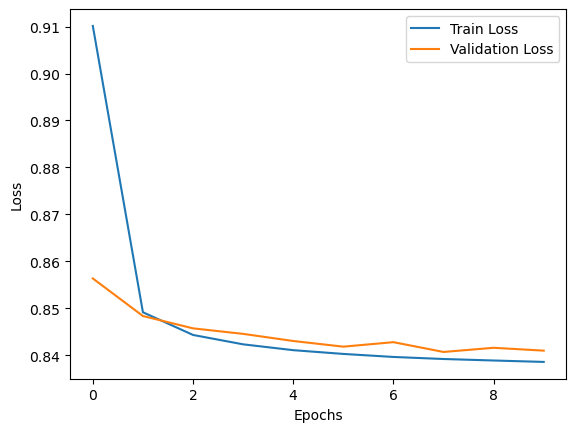

In [155]:
import pickle

def save_model_and_loss_history(model, train_loss, val_loss):
    torch.save(model.state_dict(), 'model.pth')
    loss_history = {
        'train_loss': train_loss,   
        'val_loss': val_loss        
    }

    with open('loss_history.pkl', 'wb') as f:
        pickle.dump(loss_history, f)

def load_model_and_loss_history(model_path='model.pth', loss_history_path='loss_history.pkl', device= "cpu"):
   
    model = Seq2SeqModel(
        src_vocab_size=len(russian_vocab),
        trg_vocab_size=len(english_vocab),
        emb_dim=128,
        hidden_dim=512,
        padding_idx=PAD_ID
    )

    state = torch.load(model_path, map_location=device)
    model.load_state_dict(state, strict=False)
    model.to(device)
    model.eval()

    with open(loss_history_path, 'rb') as f:
        loss_history = pickle.load(f)

    return model, loss_history


new_model, loss_history = load_model_and_loss_history()
print("Model and loss history loaded!")

plt.plot(loss_history['train_loss'], label='Train Loss')
plt.plot(loss_history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Here is the code I actually used to train the model

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

new_model = Seq2SeqModel(
    src_vocab_size=len(russian_vocab),
    trg_vocab_size=len(english_vocab),
    emb_dim=128,
    hidden_dim=512,
    padding_idx=PAD_ID
).to(device)
optimizer = optim.Adam(new_model.parameters(), lr=0.001)
new_model.to(device) 
train_loss, val_loss = train(new_model, train_loader, val_loader, PAD_ID, optimizer, device, num_epochs=10 )
save_model_and_loss_history(new_model, train_loss, val_loss)

'\n\n\n'

### Performance Review

Using the testing function we defined earlier we can see that the model has a CER of 19.5%. This intuitively means that for a string with 10 characters there are on average about 2 fixes that we can make.

This isn't great. For a task like transliteration, even from differenly sounding languages, we are learning a mapping that is nearly one-to-one. There are of course nuances involved, but we should really be in single digits for our CER. As the intention of this project was to simply see how Seq2Seq are implemented and not create the best transliteration model I will not be trying to optimize the model architecture or hyperparameters. In all honestsy, after playing around with different inputs I couldn't see why the model performance was so low, in my eyes it was actually pretty good to use. I will however note a couple of things that I thing could help for this task:
- The low hanging fruit is that we can up the parameter count and regularize accordingly, but that's lazy and inneficient
- I suspect that we don't actually need to use RNN's in the decoder, I think that the context window for characters is really small and instead a 1D CNN could be more efficient and effective
- The data does include weights of how likely a transliteration is. So far we ignored this, but I think modifying the loss function to include those weights could be simple and helpful.

In [157]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(test_model(new_model, test_loader, device, english_itos, PAD_ID, BOS_ID, EOS_ID))

tensor(0.1945)


### Using the Model

The code below lets us use the model on our wanted input. 

In [161]:
def transliterate(russian_text, model, device=device):
    """Transliterate a Russian string to English using the trained model."""

    model.eval()
    normalized_text = unicodedata.normalize("NFC", russian_text.lower())
    encoded_text = encode(normalized_text, russian_stoi)

    cpu_src = torch.tensor([encoded_text], dtype=torch.long)            
    input_tensor = cpu_src.to(device)

    with torch.no_grad():
        output = greedy_decode(model, input_tensor, BOS_ID, EOS_ID, device)

    if isinstance(output, torch.Tensor):
        out_ids = output[0].detach().cpu().tolist()
    else:
        out_ids = list(output[0])

    transliteration = decode(out_ids, english_itos)
    transliteration = transliteration.replace("<eos>", "").strip()

    print(f"Russian: {russian_text}")
    print(f"Transliteration: {transliteration}")
    print("=" * 50)
    return transliteration


def test_transliterations(words, model, device=device):
    for w in words:
        transliterate(w, model, device)



### Example Usage

- Russian: Спасибо, что прочитали этот блокнот. Ваш друг, Артём.
- English: Thank you for reading this notebook. Your friend, Artem
- Google Translate's Transliteration: Spasibo, chto prochitali etot bloknot. Vash drug, Artom.
- Our Transliteration: Spacibo, tchtho prochitali etoth bloknoth. Uash drooh, Arthiom.

I will say that I am suprised at how poor Google Translate's transliteration is. I would think that this task is something that would be trivial for them. For example, my model is actually arguably closer to the transliteration of the word friend which should be "droog" as well as my first name which should be "Artyom". Overall, my model is ok and I can see that it is very close to the proper conversion, it has learned to use the letter "h" too much for some reason. This could be a fun project to come back to and try to get a more accurate performance.

Спасибо, что прочитали этот блокнот. Ваш друг, Артём.

In [ ]:
test_transliterations(["спасибо", "что", "прочитали", "этот", "блокнот", "ваш", "друг", "артём"], model=new_model)

Russian: спасибо
Transliteration: spacibo
Russian: что
Transliteration: tchtho
Russian: прочитали
Transliteration: prochitali
Russian: этот
Transliteration: etoth
Russian: блокнот
Transliteration: bloknoth
Russian: ваш
Transliteration: uash
Russian: друг
Transliteration: drooh
Russian: артём
Transliteration: arthiom
